In [469]:
#importing necssary files
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd 
get_ipython().magic(u'matplotlib inline')
import matplotlib
import math as mt
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA

#printing versions of current packages in use 
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)

#importing the csv file containing data of sensors, sorting them and selecting the required columns
DataFile = pd.read_csv('C:/Users/muneeba/Desktop/THESIS/DataDistributionPCA.csv')
location=DataFile.iloc[:,1:3]
DataSensors=DataFile.iloc[:,4:68]

#converting the sliced data into matrices 
returns = DataSensors[[key for key in dict(DataSensors.dtypes) if dict(DataSensors.dtypes)[key] in ['float64', 'int64']]] 
returns = returns[:65]
returns_arr = returns.as_matrix()[:65]
locations = location[[key for key in dict(location.dtypes) if dict(location.dtypes)[key] in ['float64', 'int64']]] 
locations = locations[:65] 
locations_arr = locations.as_matrix()[:65]

1.13.3
0.20.3
2.1.0


In [470]:
#finding the eucledian distance 
dist=np.linalg.norm(locations_arr, axis=1)

#finding index of the sensor with maximum eucledian dianace
ind1 = np.unravel_index(np.argmax(dist, axis=None), dist.shape)
ind1
np.shape(dist)

(64,)

In [471]:
#maximum value of eucliedaian distance
maxdis=np.max(dist)
maxdis 

21.213203435596427

In [472]:
#dviding by the maximum value throughout
NormDist=np.divide(dist,maxdis)
 

In [473]:
#multiplying by lambda to scale the parameter for geographical location
#let lambda is 0.5 
DistParameter=np.multiply(0.5,NormDist)
 

In [474]:
#now adding the data part for ths algorithum
corr_mat=np.corrcoef(returns_arr,rowvar=True)
corr_mat.shape

#covariance matrix 
cov_mat = np.cov(returns_arr)
cov_mat.shape
 
 

(64, 64)

In [475]:

#similarity matrix M 
Similarity=np.subtract(corr_mat,DistParameter)
Similarity.shape
np.shape(corr_mat)

(64, 64)

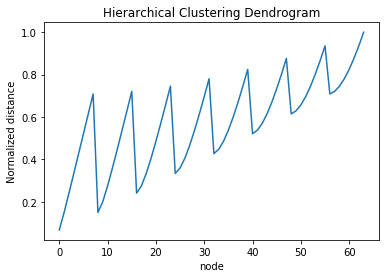

In [476]:
#building hierical dandogram for visualization
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the distance between each sample
# You have to think about the metric you use (how to measure similarity) + about the method of clusterization you use 
Z = linkage(returns)

# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('node')
plt.ylabel('Normalized distance')
node=range(64)
plt.plot(node,NormDist)
#dendrogram(Z, labels=returns.index, leaf_rotation=90)

In [477]:
cov_mat # covariance matrix
np.shape(cov_mat) #64L by 64L
corr_mat #corelstaion matrix
np.shape(corr_mat) #64L by 64L

(64, 64)

In [478]:
#jacobi function
#Input:     input covariance matrix,   correlation coeffs, masked components
#Output:   covariance of rotated data,  correlation coefficients for rotated data,      part of Jacobi rotation; rotation angle
#indices of components that are rotated,      highest correlation,      correlation coefficient for pair
# Description: Picks the two components with highest correlation coefficient. Decorrelate the two components with PCA
# maskno = components which have been already masked by this algo
     
    
from numpy import linalg as LA
global R

count =0
 

def newJacobi(C,cc,maskno):
    if (np.any(C)):
        count= +1
        if (np.any(cc)):
            count+=1
            if (maskno):
                count+=1
                 
    
     
   # maskno=np.array([]) #creating an empty array for masked components
     
    tri=np.triu(cc) #extract the uppar triangular of covariance matrix
    a=0
    if (maskno==[]):
        a=maskno[0]
    else:
        a=0
    tri[a,:]=-1
    tri[:,a]=-1  
    ind = tri.argmax(0)
    no1=ind[0]
    no2=ind[1]
    compno = [no1,no2]
    maxcc=cc[no1][no2]
    cred=np.zeros((2,2))
    cred[0][0]=C[no1][no1]
    cred[0][1]=C[no1][no2]
    cred[1][0]=C[no2][no1]
    cred[1][1]=C[no2][no2]
    if (cred[0][1]==0): # this means that already we have found diagnoal matrix
        Cnew=C
        ccnew=cc
        R=np.identity(2)
        theta=0
        idx=np.array([1,2])
    else:
        c11=cred[0][0]
        c12=cred[0][1]
        c21=cred[1][0]
        c22=cred[1][1]
        R=np.zeros((2,2))
        theta = 1/2 *(mt.atan(2*c12/(c11-c22)))
        cs=mt.cos(theta)
        sn=mt.sin(theta)
        R[0][0] =  cs
        R[0][1] = (-1)*sn
        R[1][0] = sn 
        R[1][1] = cs
        M=C
        Rtrans=R.T
        M[no1][no1]=Rtrans[0][0]*C[no1][no1]
        M[no1][no2]=Rtrans[0][1]*C[no1][no2]
        M[no2][no1]=Rtrans[1][0]*C[no2][no1]
        M[no2][no2]=Rtrans[1][1]*C[no2][no2]
        Cnew=M
        Cnew[no1][no1]=M[no1][no1]*R[0][0]
        Cnew[no1][no2]=M[no1][no2]*R[0][1]
        Cnew[no2][no1]=M[no2][no1]*R[1][0]
        Cnew[no2][no2]=M[no2][no2]*R[1][1]
        if (c11<c22):
            idx=np.array([2,1])
        else:
            idx=np.array([1,2])
        
        dnew=np.diag(Cnew)
        dnewT=dnew.T
        temp1=dnew[no1]*dnewT[no1]
        temp2=dnew[no2]*dnewT[no1]
        temp=temp1+temp2
        temp=mt.sqrt(temp)
        ccnew=cc
        ccnew[no1][:]=Cnew[no1][:]/temp
        ccnew[no2][:]=Cnew[no2][:]/temp #ccnew is 64 by 64  
        
    
   
    return  Cnew,ccnew,R,theta,compno,maxcc,idx

In [479]:
# Build a hierical clustering tree
# inputs: covariance matrix, correlation coeffs,   maxlevel  
# outputs: positions of the two clusters merged, Element T{k} in the cell array contains a 2-by-2 rot matrix , ID of prinicipal 
# components,   all_nodes,   node labels,   theta ,    rotation angles that decorrelates inputs,   PC_ratio
#ratio C_qq/C_pp , hierarchical cluster tree,  labels of the d-components in the comp,updaated covariance matrix,correlation  


import sys
global count1 
count1=0
dim=64 #no od rows od covarince matrix
dim2=64 #no. of columns od covaraince matrix

def Build_JTree(C,cc,maxlevel):
    
           
     
    if (np.any(C)):
        count1= +1
        if (np.any(cc)):
            count1+=1
            if (maxlevel):
                count1+=1
                 
                       
  
            
     
             
    J=maxlevel-1    
    Z = np.zeros((J,3))   # columns 1 and 2 contain the indices of the nodes that are merged
    T = np.ones((2,2))  # 2-by-2 rotation matrices for levels L=0,1,..,J-1
    theta = np.zeros((J,1)) #rotation angles
    PCidx=np.zeros((J,2))  # order of principal components, [1 2] or [2 1]
        
    L=0
    maskno=np.array([]) #0L
    nodes=np.zeros((1,64)) #1L by 64L
    dlabels=np.zeros((1,dim)) #1L by 64L
    PC_ratio=np.zeros((dim-1,1)) #63L by 1L
    Zpos=np.zeros((J,2)) #19L by 2L
    all_d=np.zeros((J,dim)) #19L by 64L
    all_nodes=np.zeros((J,dim)) #19L by 64L
    
    
    for lev in range (J-1):
        [Cnew,ccnew,R,th,compno,maxcc,idx]=newJacobi(C,cc,maskno)
        dist = (1-maxcc)/2
        no1=compno[0]
        no2=compno[1]
        Zpos[:][lev]=dist
        Zpos[no1][:]=nodes[0][no1]
        Zpos[no2][:]=nodes[0][no2]
        T=R
        theta[lev]=th
        PCidx[lev][:]=idx
        C=Cnew
        cc=ccnew
        component1=idx[0]
        component2=idx[1]
        pind=[component1,component2]
        p1=pind[0]
        p2=pind[1]
        nodes[0][p1]=np.array([dim+lev])
        nodes[0][p2]=np.array([dim+lev])
        dlabels[0][p2]=np.array((lev)) #abels of d-components in vector
        maskno=[maskno,p2]
        PC_ratio[lev]=C[p2][p2]/C[p1][p1]
        Zpos[lev][:] =np.array(compno) # their positions in the component vector
        transdlabels=dlabels.T
        all_d[lev][:]=transdlabels[0]
        all_nodes[lev][:]=nodes 
        
    return  Zpos,T,PCidx,maxlevel,all_nodes,Cnew,nodes

In [480]:
maxlevel=5
[Zpos,T,PCidx,maxlev,all_nodes,Cnew,nodes]=Build_JTree(cov_mat,corr_mat,maxlevel)
all_nodes

np.shape(all_nodes)
type(Zpos)
np.shape(Zpos)
Zpos
    


array([[  0.,   0.],
       [ 65.,  65.],
       [  0.,   1.],
       [  0.,   0.]])

In [481]:
Z1 = linkage(Cnew)
# Make the dendrogram
#plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('node')
#plt.ylabel('Normalized distance')
#dendrogram(Z1, labels=returns.index, leaf_rotation=90)

In [482]:
#Calculate the basis for the Jacobi tree algorithm
#inputs : hierarchical cluster information, Element T{k} in the cell array contains a 2-by-2 matrix, id of principal components  
# maxlev, node labels
#outputs : Output:   basis(m,m),    sums(J,m),  difs(J,m)  
 
global basis
def JTree_Basis(Zpos,T,PCidx,maxlev,all_nodes,nodes):
    J=np.shape(Zpos[1])
    m=np.shape(all_nodes[0])
    nodes=np.zeros((1,64))
    nodes = all_nodes[0][:]
    nodes= np.nonzero(nodes)
    del all_nodes
    tmpfilts=np.diag(np.ones(m))
    ind=np.zeros(J)
    sums=np.zeros((maxlev,64))
    difs=np.zeros((maxlev,64))
    for lev in range(4):
        d1=Zpos[lev,0:1]
        d1=int(d1)
        if d1<64:
            s=tmpfilts[d1,:]
        else:
            d2=d1-2
            s=tmpfilts[d2,:]
        R=T
        y=(R.T)*s[lev]
        if d1<64:
            tmpfilts[d1,lev]=y[0][1]
        else:
            d2=d1-2
            tmpfilts[d2,lev]=y[0][1]
        t1=PCidx[0][0]
        t2=PCidx[0][1]
        t1=int(t1)
        t2=int(t2)
        y=y[t1:t2,:]
        sums[lev,:]=y[0][0]
        difs[lev,:]=y[0][1]
        
    tmp = [np.diag(np.ones(m)), sums]
    p=np.flipud(difs)
    tt1=nodes[0][0]
           
    basis  = [tmp[tt1], p]
     
    
     
    
    return sums,difs,basis


In [483]:
maxlev=5
sums,difs,basis=JTree_Basis(Zpos,T,PCidx,maxlev,all_nodes,nodes)
np.shape(basis)
b2=basis[1][maxlev-1][:] #
b2

array([ 0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447,  0.84304447,
        0.84304447,  0.84304447,  0.84304447,  0.84304447])

In [484]:
import pandas as pd
import numpy as np
signal=DataFile.iloc[:,4:68]
T=np.sum(signal, axis=1)
T1=T/64
T1=pd.DataFrame(T1)
signal1=DataFile.iloc[:,68:69]
np.array(T1)
np.array(signal1)
s1=np.array(np.subtract(signal1,T1))
b3=b2.T 
s=b3*s1
BS=b2*s
from scipy import sparse
A = sparse.random(1, 64, density=0.5, data_rvs=np.random.randn)
p1=A*BS
p2=A*T1
np.shape(p1)
onemat=np.ones((1,64))
p3=p2*onemat
y11=p1-p3
y12=y11.T
np.shape(y12)


(64, 1)

In [485]:
 def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [500]:
n_rows = 64
n_cols = 64
sparsity = 64


A = np.random.normal(0, 1, [n_rows, n_cols])
# Generate sparse x and noise
x = np.zeros(n_cols)
x[np.random.randint(1, n_cols, [sparsity])] = np.random.chisquare(15, [sparsity])
noise = np.random.normal(0, 1, [n_cols])
A=A*b2
u = x + noise

y = np.dot(A, u)
np.shape(x)

(64,)

In [501]:
x_est = cosamp(A, y,64 )
# Score estimation
np.linalg.norm(x - x_est) / np.linalg.norm(x)

0.07898067711648854